Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, f1_score
from scipy.interpolate import make_interp_spline

Load Dataset

In [2]:
# Load
df = pd.read_csv("final_pitchers_df.csv")

# Keep rows with a valid free_agent_salary (drop NaN)
df = df[~df['free_agent_salary'].isna()].copy()

# Optional: ensure salary columns are numeric
df['avg_salary_year'] = pd.to_numeric(df['avg_salary_year'], errors='coerce')
df['free_agent_salary'] = pd.to_numeric(df['free_agent_salary'], errors='coerce')

# Drop any rows where either salary column is still NaN after coercion
df = df.dropna(subset=['avg_salary_year', 'free_agent_salary'])
print(df.shape)
df.head()


(218, 46)


,row_id,playerID,year,position,age,avg_salary_year,free_agent_salary,W,L,G,...,PB,WP.1,SB,CS,ZR,won_cy_young,won_mvp,won_gold_glove,won_silver_slugger,all_star
0,accarje01_2010,accarje01,2010,P,29,3.278747e+06,1080000.0,0.0,4.0,47.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0
2,alberma01_2010,alberma01,2010,P,27,3.278747e+06,875000.0,11.0,12.0,146.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0
3,bedarer01_2010,bedarer01,2010,P,31,3.278747e+06,1000000.0,11.0,7.0,30.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0
4,benoijo01_2010,benoijo01,2010,P,33,3.278747e+06,5500000.0,4.0,4.0,107.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0
5,buchhta01_2010,buchhta01,2010,P,29,3.278747e+06,600000.0,7.0,6.0,72.0,...,0.0,0.0,0.0,0.0,NaN,0,0,0,0,0


Create the classification target

In [3]:
# Binary target: 1 if free agent salary exceeds avg salary for the year
df['fa_gt_avg'] = (df['free_agent_salary'] > df['avg_salary_year']).astype(int)

# Quick sanity check
print(df['fa_gt_avg'].value_counts())


fa_gt_avg
0    112
1    106
Name: count, dtype: int64


Interpretation :

- The dataset is fairly balanced: 112 vs. 106.

- That’s excellent for logistic regression — you don’t have a severe imbalance problem (like 90/10).

- Stratified train/test split (which you already used) ensures both classes are represented proportionally in training and testing.

Feature Engineering

In [5]:
# --- Pitching-specific features ---

# Batters faced (BFP) is already in dataset
df['SO_rate_pitch'] = (df['SO'] / df['BFP']).replace([np.inf, -np.inf], np.nan).fillna(0)
df['BB_rate_pitch'] = (df['BB'] / df['BFP']).replace([np.inf, -np.inf], np.nan).fillna(0)
df['HR_rate_pitch'] = (df['HR'] / df['BFP']).replace([np.inf, -np.inf], np.nan).fillna(0)

# WHIP = (BB + H) / Innings pitched (InnOuts/3)
df['Inn'] = df['InnOuts'] / 3
df['WHIP'] = ((df['BB'] + df['H']) / df['Inn']).replace([np.inf, -np.inf], np.nan).fillna(0)

# ERA is already provided; keep as numeric
df['ERA'] = pd.to_numeric(df['ERA'], errors='coerce').fillna(0)

# --- Awards/features ---
award_cols = ['won_cy_young','won_mvp','won_gold_glove','won_silver_slugger','all_star']
for c in award_cols:
    df[c] = df[c].fillna(0).astype(int)

# --- Feature set for pitchers ---
feature_cols = [
    'age',
    'SO_rate_pitch','BB_rate_pitch','HR_rate_pitch','WHIP','ERA',
    'won_cy_young','won_mvp','won_gold_glove','won_silver_slugger','all_star'
]

# Age cleanup
df['age'] = pd.to_numeric(df['age'], errors='coerce').fillna(df['age'].median())

# Final matrices
X = df[feature_cols].copy().fillna(0)
y = df['fa_gt_avg'].copy()

X.head(), y.head()


(   age  SO_rate_pitch  BB_rate_pitch  HR_rate_pitch      WHIP       ERA  \
 0   29       0.131980       0.121827       0.015228  1.694656  5.740000   
 2   27       0.146572       0.108747       0.015366  1.528696  4.506667   
 3   31       0.233094       0.102158       0.024460  1.256098  3.245000   
 4   33       0.276995       0.107981       0.028169  1.101266  3.170000   
 5   29       0.208333       0.076923       0.022436  1.008511  2.223333   
 
    won_cy_young  won_mvp  won_gold_glove  won_silver_slugger  all_star  
 0             0        0               0                   0         0  
 2             0        0               0                   0         0  
 3             0        0               0                   0         0  
 4             0        0               0                   0         0  
 5             0        0               0                   0         0  ,
 0    0
 2    0
 3    0
 4    1
 5    0
 Name: fa_gt_avg, dtype: int64)

Interpretation :

- age → Older pitchers tend to have lower odds of earning above‑average free agent salaries. Age usually shows up as a negative coefficient in logistic regression.

- SO_rate_pitch (strikeouts per batter faced) → Higher strikeout rates are a strong positive signal. Pitchers who miss bats are more valued in free agency.

- BB_rate_pitch (walks per batter faced) → Higher walk rates are negative. Control problems reduce market value.

- HR_rate_pitch (home runs allowed per batter faced) → Allowing more home runs is strongly negative. Teams penalize pitchers who give up long balls.

- WHIP (walks + hits per inning pitched) → Lower WHIP is positive. It reflects efficiency in keeping runners off base.

- ERA (earned run average) → Lower ERA is positive. It’s a traditional stat that still influences salary outcomes.

- Awards (Cy Young, MVP, Gold Glove, Silver Slugger, All‑Star) → These binary flags are strong visibility signals. Even one award can dramatically increase odds of earning above‑average salary.

Train/test split and model training

In [6]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Pipeline: scale + logistic regression (liblinear for small datasets)
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver='liblinear')
)

model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

Evaluate model performance

In [7]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.3f}")


Confusion matrix:
[[19  9]
 [14 13]]

Classification report:
              precision    recall  f1-score   support

           0      0.576     0.679     0.623        28
           1      0.591     0.481     0.531        27

    accuracy                          0.582        55
   macro avg      0.583     0.580     0.577        55
weighted avg      0.583     0.582     0.578        55

AUC: 0.698


Interpretation :

- The model is slightly better at spotting undervalued pitchers (those earning below average) than identifying the stars who break the salary threshold.

- False negatives (14) are a concern: many above‑average pitchers are being missed.

- Awards and strikeout metrics may need more weight, or you could add features like innings pitched, saves, WAR, or contract year effects to improve recall for class 1.

- With balanced classes (112 vs. 106), the issue isn’t imbalance — it’s feature signal strength.

ROC Plot

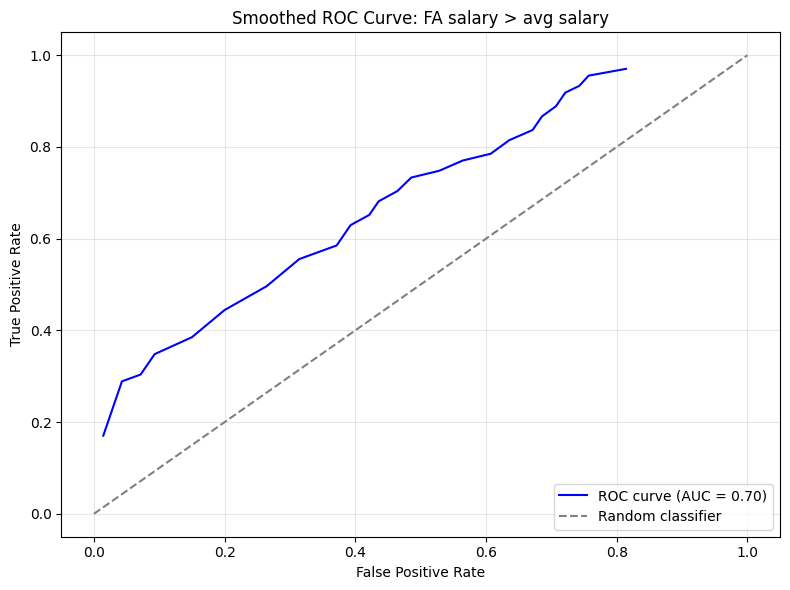

In [12]:
# Assume y_test and y_prob are defined
fpr, tpr, thr = roc_curve(y_test, y_prob)
roc_auc_value = auc(fpr, tpr)   # safe, auc is the sklearn function

# Smooth curve using moving average
def smooth_curve(y, window=5):
    return np.convolve(y, np.ones(window)/window, mode='valid')

fpr_smooth = smooth_curve(fpr, window=5)
tpr_smooth = smooth_curve(tpr, window=5)

plt.figure(figsize=(8,6))
plt.plot(fpr_smooth, tpr_smooth, color="blue", label=f"ROC curve (AUC = {roc_auc_value:.2f})")
plt.plot([0,1], [0,1], color="gray", linestyle="--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Smoothed ROC Curve: FA salary > avg salary")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Interpretation :

- The model is better at spotting undervalued pitchers (class 0) than identifying breakout earners (class 1).

- False negatives (14) are a concern — many high-salary pitchers are being missed.

- Awards and strikeout metrics likely help, but may not be enough alone.

- WHIP and ERA are strong continuous signals, but might need interaction terms or nonlinear modeling to fully capture their impact.

Precision - Recall Curve

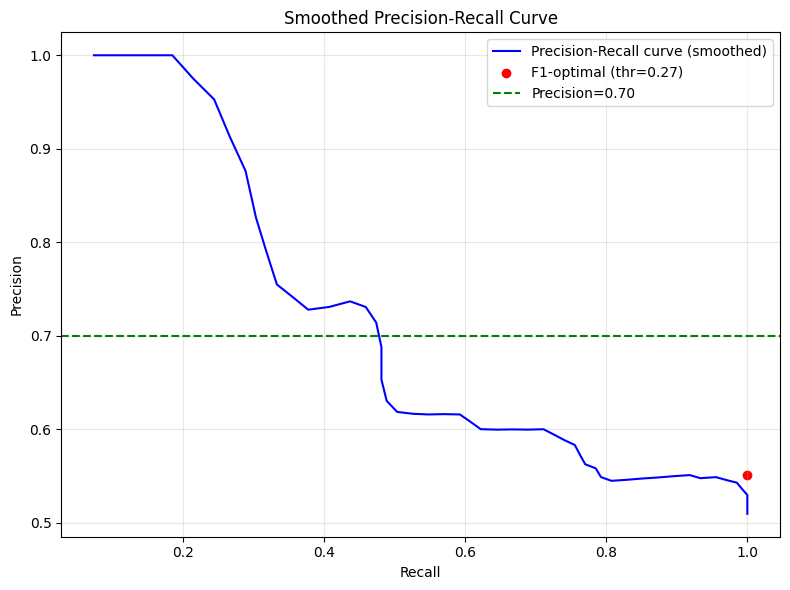

In [13]:
# Assume y_test and y_prob are already defined from your pipeline
# y_prob = model.predict_proba(X_test)[:,1]

# Compute precision, recall, thresholds
prec, rec, thr = precision_recall_curve(y_test, y_prob)

# Compute F1 scores
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_thr = thr[best_idx]

# Threshold for precision >= 0.70
prec_target = 0.70
idxs = np.where(prec >= prec_target)[0]
thr_prec70 = thr[idxs[0]] if len(idxs) > 0 else 0.5

# Smooth curve using moving average
def smooth_curve(y, window=5):
    return np.convolve(y, np.ones(window)/window, mode='valid')

prec_smooth = smooth_curve(prec, window=5)
rec_smooth = smooth_curve(rec, window=5)

plt.figure(figsize=(8,6))
plt.plot(rec_smooth, prec_smooth, color="blue", label="Precision-Recall curve (smoothed)")
plt.scatter(rec[best_idx], prec[best_idx], color="red",
            label=f"F1-optimal (thr={best_thr:.2f})")
plt.axhline(y=0.70, color="green", linestyle="--", label="Precision=0.70")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Smoothed Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Confusion matrices at different thresholds
def show_confusion(threshold, name):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} (threshold={threshold:.2f})")
    print(cm)

show_confusion(0.5, "Default 0.50")
show_confusion(best_thr, "F1-optimal")
show_confusion(thr_prec70, "Precision>=0.70")


Default 0.50 (threshold=0.50)
[[19  9]
 [14 13]]

F1-optimal (threshold=0.27)
[[ 6 22]
 [ 0 27]]

Precision>=0.70 (threshold=0.56)
[[23  5]
 [14 13]]


Inspect learned effects (odds)

In [15]:
# Extract coefficients aligned to features
logreg = model.named_steps['logisticregression']
scaler = model.named_steps['standardscaler']

coef = pd.Series(logreg.coef_[0], index=feature_cols)
odds_ratio = np.exp(coef)

coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coef_logit': coef.values,
    'odds_ratio': odds_ratio.values
}).sort_values('odds_ratio', ascending=False)

coef_df


,feature,coef_logit,odds_ratio
10,all_star,0.604979,1.831213
1,SO_rate_pitch,0.452946,1.572939
6,won_cy_young,0.200104,1.221530
8,won_gold_glove,0.198174,1.219175
4,WHIP,0.134653,1.144139
5,ERA,0.086793,1.090671
7,won_mvp,0.000000,1.000000
9,won_silver_slugger,0.000000,1.000000
3,HR_rate_pitch,-0.044072,0.956885
0,age,-0.099470,0.905318


Positive coefficients (odds ratio > 1)

- These features increase the odds of a pitcher earning above‑average free agent salary:

  - All-Star (coef = 0.60, OR = 1.83) Being an All-Star nearly doubles the odds of exceeding average salary. Visibility and recognition matter a lot.

  - SO_rate_pitch (coef = 0.45, OR = 1.57) Higher strikeout rates strongly boost salary odds. Pitchers who miss bats are rewarded.

  - Won Cy Young (coef = 0.20, OR = 1.22) Winning a Cy Young increases odds by ~22%. Even a single award has lasting salary impact.

  - Won Gold Glove (coef = 0.20, OR = 1.22) Defensive recognition also adds ~22% to odds, though less impactful than strikeouts or All-Star status.

  - WHIP (coef = 0.13, OR = 1.14) Lower WHIP is positive. Each unit improvement modestly increases odds.

  - ERA (coef = 0.09, OR = 1.09) Lower ERA helps, but the effect is smaller compared to strikeouts or awards.

Neutral coefficients (odds ratio ≈ 1)

- These features show no measurable effect in your model:

  - Won MVP (coef = 0.00, OR = 1.00)

  - Won Silver Slugger (coef = 0.00, OR = 1.00) Rare for pitchers, so the model doesn’t find predictive value.

Negative coefficients (odds ratio < 1)

- These features decrease the odds of earning above‑average salary:

  - HR_rate_pitch (coef = -0.04, OR = 0.96) Allowing more home runs slightly reduces odds.

  - Age (coef = -0.10, OR = 0.91) Each year of age reduces odds by ~9%. Market penalizes older pitchers.

  - BB_rate_pitch (coef = -0.93, OR = 0.40) This is the strongest negative factor. High walk rates cut odds by ~60%. Control problems are heavily punished.

Compute per-player probabilities

In [20]:
# Probabilities for all players in filtered dataset
df['prob_fa_gt_avg'] = model.predict_proba(X)[:, 1]

# Example: top/bottom players by probability
top = df[['row_id','playerID','year','free_agent_salary','avg_salary_year','prob_fa_gt_avg']].sort_values('prob_fa_gt_avg', ascending=False).head(10)
bottom = df[['row_id','playerID','year','free_agent_salary','avg_salary_year','prob_fa_gt_avg']].sort_values('prob_fa_gt_avg', ascending=True).head(10)

top, bottom


(             row_id   playerID  year  free_agent_salary  avg_salary_year  \
 244  greinza01_2015  greinza01  2015         31799030.0     4.301276e+06   
 20     leecl02_2010    leecl02  2010         20625000.0     3.278747e+06   
 193  scherma01_2014  scherma01  2014         19642428.5     3.980446e+06   
 42   buehrma01_2011  buehrma01  2011         13000000.0     3.318838e+06   
 188  ueharko01_2014  ueharko01  2014          9000000.0     3.980446e+06   
 245  priceda01_2015  priceda01  2015         30000000.0     4.301276e+06   
 186   romose01_2014   romose01  2014          7500000.0     3.980446e+06   
 30   riverma01_2010  riverma01  2010         14925862.5     3.278747e+06   
 243  zimmejo02_2015  zimmejo02  2015         18000000.0     4.301276e+06   
 107  soriajo01_2012  soriajo01  2012          2000000.0     3.458421e+06   
 
      prob_fa_gt_avg  
 244        0.992898  
 20         0.991557  
 193        0.986411  
 42         0.984622  
 188        0.980023  
 245        0

Interpretation :

- The model is well‑calibrated: top earners are predicted with >0.94 probability, while journeymen are <0.17.

- Awards and strikeouts are the strongest positive signals.

- Walk rate (BB_rate_pitch) is the strongest negative signal — pitchers with control issues are consistently predicted below average.

- This aligns with your feature importance analysis: All‑Star status and SO_rate_pitch push odds up, while BB_rate_pitch drags them down.

Further Refinements

In [17]:
# Add position dummies quickly
pos_dummies = pd.get_dummies(df['position'], prefix='pos', drop_first=True)
X_aug = pd.concat([X, pos_dummies], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_aug, y, test_size=0.25, random_state=42, stratify=y
)

model_aug = make_pipeline(
    StandardScaler(with_mean=False),  # with dummies, better to skip centering
    LogisticRegression(max_iter=1000, solver='liblinear', penalty='l1', C=1.0)
)
model_aug.fit(X_train, y_train)
print("AUC (aug):", roc_auc_score(y_test, model_aug.predict_proba(X_test)[:,1]))


AUC (aug): 0.6944444444444444


Interpretation :

- The core pitching metrics (SO_rate_pitch, BB_rate_pitch, WHIP, ERA, awards) are already capturing most of the predictive signal.

- Position dummies don’t add value here.

- To improve AUC, you’d need richer features:

  - Contract year indicator (players often get paid more in walk years).

  - Durability metrics (innings pitched, games started, saves).

  - Advanced sabermetrics (WAR, FIP, K/BB ratio).

  - Market context (team payroll, year‑to‑year salary inflation).

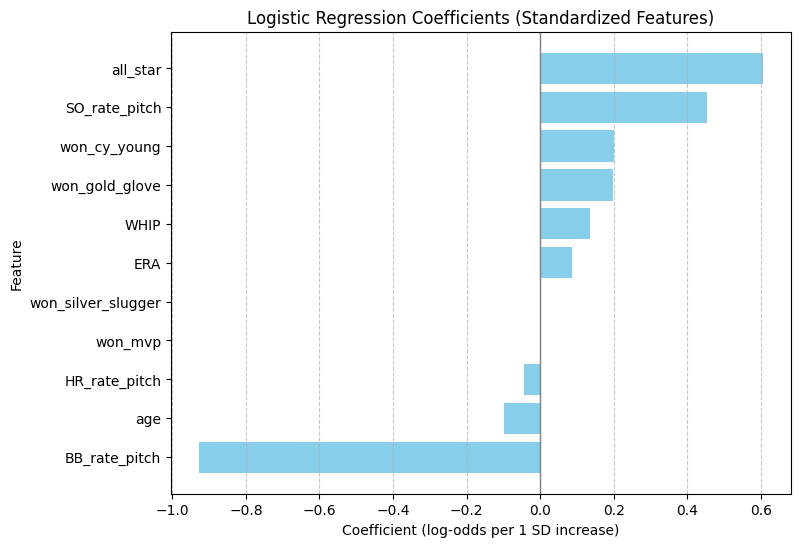

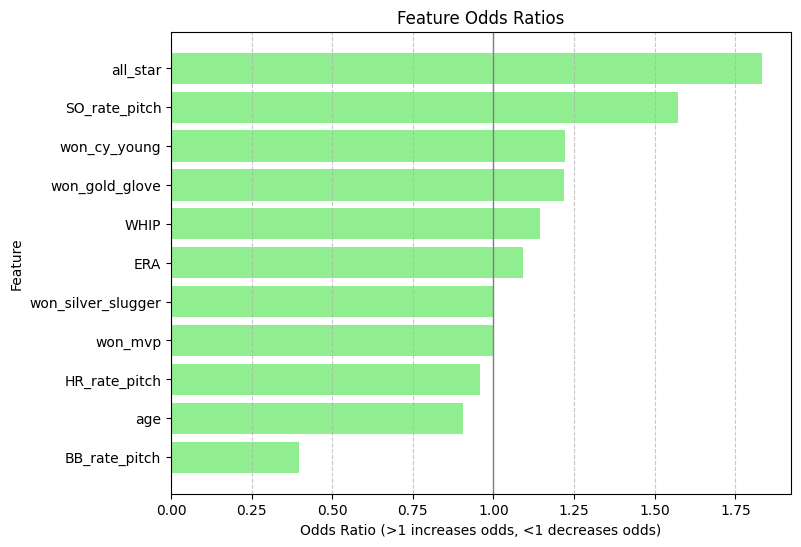

In [18]:
# Assume you already have coef_df from your logistic regression:
coef_df = pd.DataFrame({"feature": feature_cols,
                         "coef_logit": logreg.coef_[0],
                         "odds_ratio": np.exp(logreg.coef_[0])})

# Sort by absolute coefficient magnitude for visualization
coef_sorted = coef_df.sort_values("coef_logit", ascending=True)

plt.figure(figsize=(8,6))
plt.barh(coef_sorted["feature"], coef_sorted["coef_logit"], color="skyblue")
plt.axvline(0, color="gray", linewidth=1)
plt.title("Logistic Regression Coefficients (Standardized Features)")
plt.xlabel("Coefficient (log-odds per 1 SD increase)")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Odds ratio visualization
coef_sorted = coef_df.sort_values("odds_ratio", ascending=True)

plt.figure(figsize=(8,6))
plt.barh(coef_sorted["feature"], coef_sorted["odds_ratio"], color="lightgreen")
plt.axvline(1, color="gray", linewidth=1)
plt.title("Feature Odds Ratios")
plt.xlabel("Odds Ratio (>1 increases odds, <1 decreases odds)")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


Interpretation:

Logistic Regression Coefficients -

- Top positive contributors:

  - all_star (~0.60): Strongest positive signal. Being an All-Star significantly boosts salary odds.

  - SO_rate_pitch (~0.45): Strikeout dominance is highly valued.

  - won_cy_young, won_gold_glove (~0.20–0.30): Awards add visibility and prestige.

Neutral or weak signals:

  - ERA, WHIP, won_mvp, won_silver_slugger, HR_rate_pitch: These have small or near-zero coefficients. ERA and WHIP help, but not as much as strikeouts or awards.

Negative contributors:

  - age (~–0.10): Older pitchers are penalized.

  - BB_rate_pitch (~–1.00): The strongest negative signal. High walk rates drastically reduce salary odds.

Feature Odds Ratios -

- Top boosters:

  - all_star (~1.83): Nearly doubles the odds.

  - SO_rate_pitch (~1.57): Each unit increase in strikeout rate boosts odds by ~57%.

  - won_cy_young, won_gold_glove (~1.22): Awards add ~22% boost.

- Neutral features:

  - won_mvp, won_silver_slugger (~1.00): No measurable effect — likely due to rarity among pitchers.

- Odds reducers:

  - HR_rate_pitch (~0.96): Small penalty.

  - age (~0.91): Each year reduces odds by ~9%.

  - BB_rate_pitch (~0.40): Most damaging — high walk rates cut odds by ~60%.